In [16]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import csv
import time

# Dataset

In [17]:
path = "GetData/Rust/get_data_rust/Data/FirstSet"

In [18]:
try:
    reader = csv.DictReader(open(f"{path}/parameters.csv"))
    par_dict = next(reader) 
except:
    raise ValueError("Invalid folder provided")
print("Parameters used in this dataset:")
par_dict

Parameters used in this dataset:


{'Steps': '1000',
 'Simulatiton Number': '1000',
 'Temperature': '2.73',
 'Magnetic Field': '0',
 'Mattize Size': '64'}

In [14]:
def load_npy_file(file_path):
    return np.load(file_path)

def load_numpy_file_wrapper(file_path):
    return tf.numpy_function(load_npy_file, [file_path], tf.int32)

def benchmark(dataset, num_epochs=1):
    start_time = time.perf_counter()
    count = 0
    for epoch_num in range(num_epochs):
        for sample in dataset:
            count+=sample.shape[0]
            # Performing a training step
            time.sleep(1E-10)
    tf.print("Number of examples: ",count)       
    tf.print("Execution time:", time.perf_counter() - start_time) 

def dataset_pipeline(path, num_epochs=1):
    ''' Path folder contains data representing spin configurations in a 2D mattize.
    The data is stored in .npy format.
    '''
    print("Getting data from " + path)
    dataset = tf.data.Dataset.list_files(f"{path}/*/*.npy")
    print(f"Got {len(dataset)} samples")
    dataset = dataset.map(load_numpy_file_wrapper)
    dataset = dataset.map(lambda x: tf.reshape(x, [-1]))
    dataset = dataset.map(lambda x: tf.cast(x, tf.float32))
    benchmark(dataset, num_epochs)
    return dataset

In [15]:
%%time
dataset = dataset_pipeline(path)

Getting data from GetData/Rust/get_data_rust/Data/FirstSet
Got 1000 samples
Number of examples:  4096000
Execution time: 1.04679152800054
CPU times: user 844 ms, sys: 264 ms, total: 1.11 s
Wall time: 1.36 s


# Model

### Restricted Boltzman Machine

In [6]:
class RBM:
    def __init__(self, num_visible, num_hidden, learning_rate):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.learning_rate = learning_rate
        self.W = tf.Variable(tf.random.normal([num_visible, num_hidden]))
        self.visible_bias = tf.Variable(tf.zeros([num_visible]))
        self.hidden_bias = tf.Variable(tf.zeros([num_hidden]))

    def sample_h_given_v(self, v):
        p_h_given_v = tf.nn.sigmoid(tf.matmul(v, self.W) + self.hidden_bias)
        p = tf.random.uniform(shape = p_h_given_v.shape)
        h_new = tf.cast(p_h_given_v <= p, dtype=tf.float32)
        return h_new, p_h_given_v

    def sample_v_given_h(self, h):
        p_v_given_h = tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.visible_bias)
        p = tf.random.uniform(shape = p_v_given_h.shape)
        v_new = tf.cast(p_v_given_h <= p, dtype=tf.float32)
        return v_new
    
    def train(self, dataset, num_epochs, batch_size):
        train_ds = dataset.repeat(num_epochs).batch(batch_size)
        n = len(train_ds)
        for i, v0 in enumerate(train_ds):
            h0, h0_prob = self.sample_h_given_v(v0)
            v_new = self.sample_v_given_h(h0)
            h_new, h_new_prob = self.sample_h_given_v(v0)
            reconstruction_loss = tf.reduce_mean(tf.square(v0 - v_new))
            self.backward(v0, h0_prob, v_new, h_new_prob)

            if i % 5 == 0:
                print(f"Progress {i}/{n}, Average Loss: {reconstruction_loss:.5f}")
        print("Training completed.")

    def backward(self, v0, h0_prob, v_new, h_new_prob):
        d_vb = tf.reduce_sum(v0, axis=0)-tf.reduce_sum(v_new, axis=0)
        d_hb = tf.reduce_sum(h0_prob, axis=0)-tf.reduce_sum(h_new_prob, axis=0)
        d_W = tf.matmul(tf.transpose(v0), h0_prob) - tf.matmul(tf.transpose(v_new), h_new_prob)
        self.W.assign_add(self.learning_rate * d_W)
        self.hidden_bias.assign_add(self.learning_rate * d_hb)
        self.visible_bias.assign_add(self.learning_rate * d_vb)

    def generate(self, num_samples):
        samples = tf.random.uniform(shape=[num_samples, self.num_visible])
        for _ in range(100):  # Perform 100 Gibbs sampling steps for mixing
            hidden_samples, _ = self.sample_h_given_v(samples)
            samples = self.sample_v_given_h(hidden_samples)
        return samples

In [7]:
rbm = RBM(num_visible=int(par_dict['Mattize Size'])**2, num_hidden=64, learning_rate=0.0001)
rbm.train(dataset, num_epochs=4, batch_size=20)

Progress 0/200, Average Loss: 1.26395
Progress 5/200, Average Loss: 1.52107
Progress 10/200, Average Loss: 1.56422
Progress 15/200, Average Loss: 1.49380
Progress 20/200, Average Loss: 1.34794
Progress 25/200, Average Loss: 1.54252
Progress 30/200, Average Loss: 1.44706
Progress 35/200, Average Loss: 1.36074
Progress 40/200, Average Loss: 1.57941
Progress 45/200, Average Loss: 1.31456
Progress 50/200, Average Loss: 1.52709
Progress 55/200, Average Loss: 1.69315
Progress 60/200, Average Loss: 1.56544
Progress 65/200, Average Loss: 1.46885
Progress 70/200, Average Loss: 1.50237
Progress 75/200, Average Loss: 1.59954
Progress 80/200, Average Loss: 1.61033
Progress 85/200, Average Loss: 1.44548
Progress 90/200, Average Loss: 1.65734
Progress 95/200, Average Loss: 1.62769
Progress 100/200, Average Loss: 1.37386
Progress 105/200, Average Loss: 1.50643
Progress 110/200, Average Loss: 1.56111
Progress 115/200, Average Loss: 1.34403
Progress 120/200, Average Loss: 1.65746
Progress 125/200, Aver

# Compare model to monte carlo algorithm
The goal of this project is to recreate probability distribution of spin configurations in Ising Model using deep learning methods <br>
Below few samples from monte carlo dataset are compared with those created by RBM model. They dont have to be the same as we are sampling randomly but they should<br>
be similar on average.

In [8]:
data_generated = rbm.generate(10)
data_sample = list(dataset.take(10))

In [9]:
def compare_plot(data_sample, data_generated):
    n_rows = len(data_sample)
    fig = plt.figure(constrained_layout=True, figsize=(8, 32))
    subfigs = fig.subfigures(nrows=n_rows, ncols=1)

    for index, subfig in enumerate(subfigs):
        axs = subfig.subplots(nrows=1, ncols=2)

        axs[0].imshow(tf.reshape(data_generated[index], (64,64)) )
        axs[0].set_title(f'RBM')

        axs[1].imshow(tf.reshape(data_sample[index], (64,64)) )
        axs[1].set_title(f'Monte Carlo')

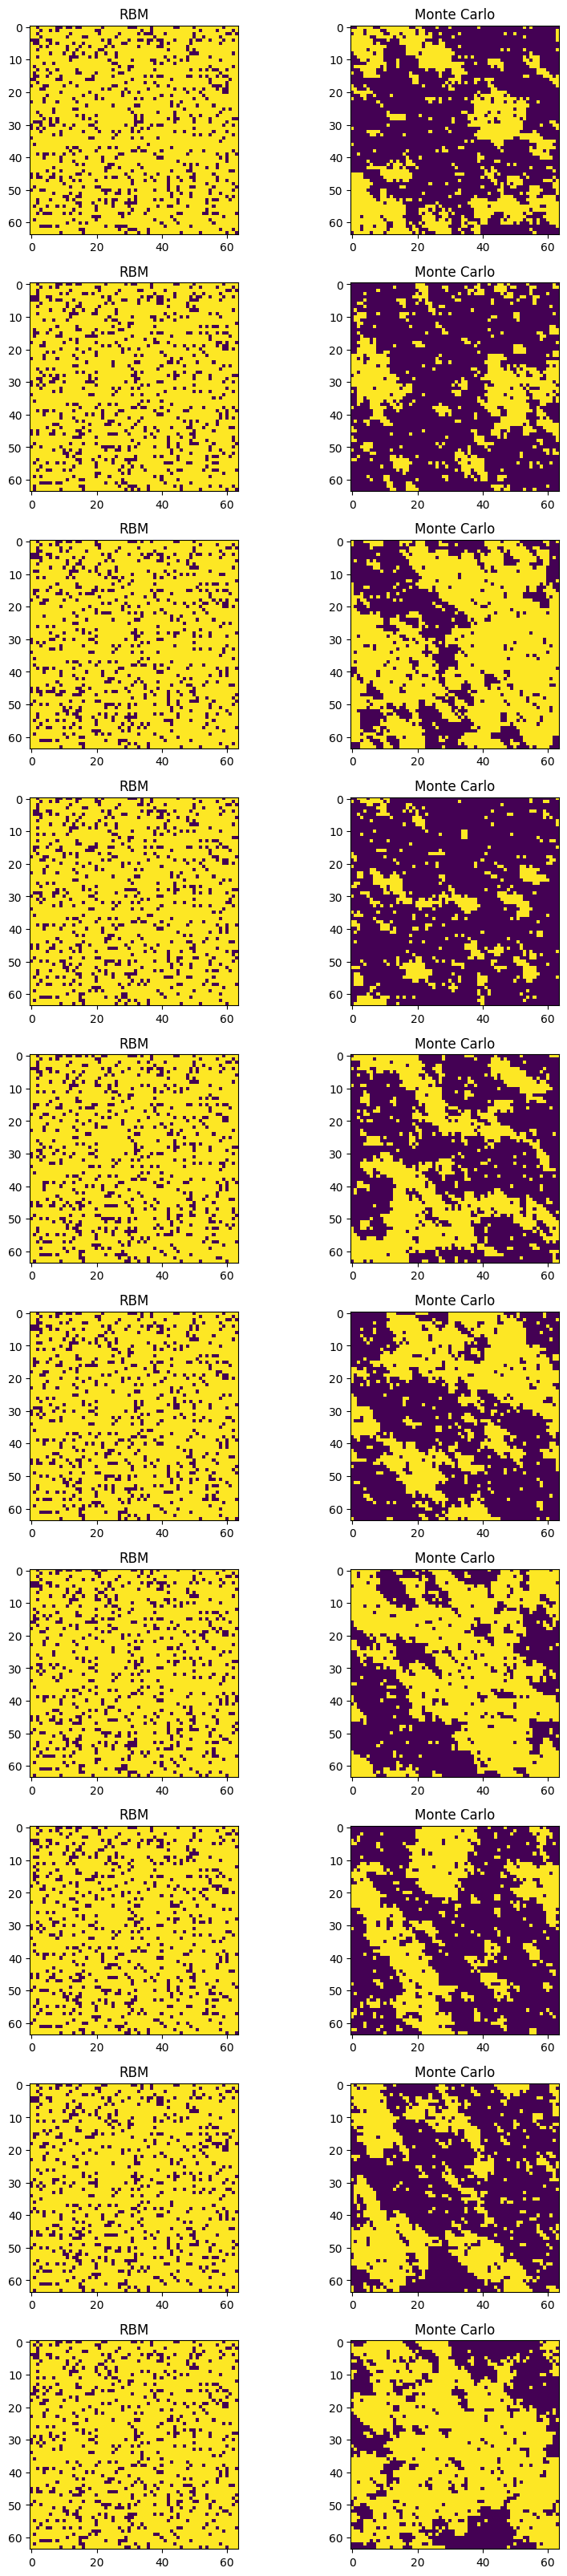

In [10]:
compare_plot(data_sample, data_generated)